In [3]:
%matplotlib inline

from pathlib import Path
from collections import Counter, OrderedDict

import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist

import tensorflow as tf
    
import pickle

import os

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns



from collections import OrderedDict

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import joblib

import re
import sys

from random import randint

import pyLDAvis
from pyLDAvis.sklearn import prepare

from wordcloud import WordCloud
from termcolor import colored
import spacy
from spacy import displacy
from textacy.extract import ngrams, entities
from textblob import TextBlob, Word

from nltk.corpus import stopwords
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
# gensim for alternative models
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.matutils import Sparse2Corpus


c:\Users\JBarr\anaconda3\envs\blockchainDev\lib\site-packages\gensim\matutils.py:22: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu


In [4]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Reshape, Dot, Embedding
from tensorflow.keras.preprocessing.sequence import skipgrams, make_sampling_table
from tensorflow.keras.callbacks import Callback, TensorBoard



In [5]:
np.random.seed(42)
sns.set_style('whitegrid')
pd.options.display.float_format = '{:,.2f}'.format
plt.rcParams['figure.figsize'] = (14.0, 8.7)
pyLDAvis.enable_notebook()

In [6]:



def tokenizerdos(text):
    return text.split()


def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]




def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')
    tokenized = [w for w in text.split() if w not in stop]
    return tokenized

def stream_docs(path):
    with open(path, 'r', encoding='utf-8') as csv:
        next(csv) # skip header
        for line in csv:
            text, label = line[:-3], int(line[-2])
            yield text, label
            
def get_minibatch(doc_stream, size):
    docs, y = [], []
    try:
        for _ in range(size):
            text, label = next(doc_stream)
            docs.append(text)
            y.append(label)
    except StopIteration:
        return None, None
    return docs, y




import re
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                           text)
    text = (re.sub('[\W]+', ' ', text.lower()) +
            ' '.join(emoticons).replace('-', ''))
    return text


def lemmatizer(text):
    words = TextBlob(text.lower()).words
    return [word.lemmatize() for word in words]

<>:13: DeprecationWarning: invalid escape sequence \)
<>:14: DeprecationWarning: invalid escape sequence \W
<>:42: DeprecationWarning: invalid escape sequence \)
<>:44: DeprecationWarning: invalid escape sequence \W
<>:13: DeprecationWarning: invalid escape sequence \)
<>:14: DeprecationWarning: invalid escape sequence \W
<>:42: DeprecationWarning: invalid escape sequence \)
<>:44: DeprecationWarning: invalid escape sequence \W
C:\Users\JBarr\AppData\Local\Temp\ipykernel_12008\1670621178.py:13: DeprecationWarning: invalid escape sequence \)
  emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
C:\Users\JBarr\AppData\Local\Temp\ipykernel_12008\1670621178.py:14: DeprecationWarning: invalid escape sequence \W
  text = re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')
C:\Users\JBarr\AppData\Local\Temp\ipykernel_12008\1670621178.py:42: DeprecationWarning: invalid escape sequence \)
  emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
C:\Users\JBa

In [7]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')
    

Using GPU


In [8]:
n_components = 5
topic_labels = ['Topic {}'.format(i) for i in range(1, n_components + 1)]

max_df = .2
min_df = 3
max_features = 2000

# used by sklearn: https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/feature_extraction/stop_words.py
stop_words = pd.read_csv('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words', 
                         header=None, 
                         squeeze=True).tolist()


C:\Users\JBarr\AppData\Local\Temp\ipykernel_12008\1404930559.py:9: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  stop_words = pd.read_csv('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words',


In [9]:
path =  Path('./data/bbc')
files = sorted(list(path.glob('**/*.txt')))
doc_list = []
for i, file in enumerate(files):
    with open(str(file), encoding='latin1') as f:
        topic = file.parts[-2]
        lines = f.readlines()
        heading = lines[0].strip()
        body = ' '.join([l.strip() for l in lines[1:]])
        doc_list.append([topic.capitalize(), heading, body])
        


In [10]:



docss = pd.DataFrame(doc_list, columns=['Category', 'Heading', 'Article'])


train_docs, test_docs = train_test_split(docss,
                                         stratify=docss.Category,
                                         test_size= .5,
                                         random_state=42)



countvectorizer = CountVectorizer(max_df=max_df, 
                             min_df=min_df, 
                             stop_words=stop_words, 
                             max_features=max_features)

train_dtm = countvectorizer.fit_transform(train_docs.Article)
test_dtm = countvectorizer.transform(test_docs.Article)


lda_base = LatentDirichletAllocation(n_components=n_components,
                                     n_jobs=10,
                                     learning_method='batch',
                                     max_iter=10)
lda_base.fit(train_dtm)


LatentDirichletAllocation(n_components=5, n_jobs=10)

In [11]:
lda_opt = LatentDirichletAllocation(n_components=5,
                                    n_jobs=-1,
                                    max_iter=500,
                                    learning_method='batch',
                                    evaluate_every=5,
                                    verbose=1,
                                    random_state=42)
lda_opt.fit(train_dtm)

iteration: 1 of max_iter: 500
iteration: 2 of max_iter: 500
iteration: 3 of max_iter: 500
iteration: 4 of max_iter: 500
iteration: 5 of max_iter: 500, perplexity: 1210.8533
iteration: 6 of max_iter: 500
iteration: 7 of max_iter: 500
iteration: 8 of max_iter: 500
iteration: 9 of max_iter: 500
iteration: 10 of max_iter: 500, perplexity: 1145.4206
iteration: 11 of max_iter: 500
iteration: 12 of max_iter: 500
iteration: 13 of max_iter: 500
iteration: 14 of max_iter: 500
iteration: 15 of max_iter: 500, perplexity: 1137.4827
iteration: 16 of max_iter: 500
iteration: 17 of max_iter: 500
iteration: 18 of max_iter: 500
iteration: 19 of max_iter: 500
iteration: 20 of max_iter: 500, perplexity: 1135.8884
iteration: 21 of max_iter: 500
iteration: 22 of max_iter: 500
iteration: 23 of max_iter: 500
iteration: 24 of max_iter: 500
iteration: 25 of max_iter: 500, perplexity: 1135.1135
iteration: 26 of max_iter: 500
iteration: 27 of max_iter: 500
iteration: 28 of max_iter: 500
iteration: 29 of max_iter:

LatentDirichletAllocation(evaluate_every=5, max_iter=500, n_components=5,
                          n_jobs=-1, random_state=42, verbose=1)

In [12]:
joblib.dump(lda_base, 'lda_10_iter.pkl')

    
joblib.dump(lda_opt, 'lda_11_iter.pkl')

lda_base = joblib.load('lda_10_iter.pkl') 
lda_base = joblib.load('lda_11_iter.pkl') 


In [13]:



vectorizer = CountVectorizer(analyzer=lemmatizer, decode_error='replace')



y = pd.factorize(docss.Category)[0]
X = docss.Article
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

vectorizer = CountVectorizer()
X_train_dtm = vectorizer.fit_transform(X_train)
X_test_dtm = vectorizer.transform(X_test)


nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)
y_pred_class = nb.predict(X_test_dtm)

In [14]:
X_train_dtm = vectorizer.fit_transform(X_train)
X_test_dtm = vectorizer.transform(X_test)

In [15]:
pd.DataFrame(confusion_matrix(y_true=y_test, y_pred=y_pred_class))

,0,1,2,3,4
0,120,0,6,0,2
1,0,94,2,0,1
2,1,0,103,0,0
3,0,0,1,127,0
4,0,1,2,0,97


In [16]:
# change to your data path if necessary
DATA_DIR = Path('./data/')
data_path = DATA_DIR / 'earnings_calls'

files = sorted(list(data_path.glob('**/*.csv')))
doc_list2 = []
for i  in (files):
    with open(str(i), encoding='latin1') as f:
        topic = i.parts[-2]
        lines = f.readlines()
        heading = lines[0].strip()
        body = ' '.join([l.strip() for l in lines[1:]])
        doc_list2.append([topic.upper(), heading, body])
        
docs = pd.DataFrame(doc_list2,  columns=['Ticker', 'heading', 'article'])



docs['article'], docs['heading'] = docs['article'].apply(preprocessor), docs['heading'].apply(preprocessor)

docs.drop(columns='heading', inplace=True)

readyFiles = docs.groupby(['Ticker']).max()

train_docs, test_docs = train_test_split(readyFiles, 
                                         test_size=.45, 
                                         random_state=42)


In [17]:
vectorizer = CountVectorizer(max_df=max_df, 
                             min_df=min_df, 
                             stop_words='english', 
                             max_features=max_features)

train_dtm = vectorizer.fit_transform(train_docs.article)
test_dtm = vectorizer.transform(test_docs.article)

train_corpus = Sparse2Corpus(train_dtm, documents_columns=False)
test_corpus = Sparse2Corpus(test_dtm, documents_columns=False)
id2word = pd.Series(vectorizer.get_feature_names()).to_dict()

c:\Users\JBarr\anaconda3\envs\blockchainDev\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [18]:
LdaModel(corpus=train_corpus, 
         num_topics=100, 
         id2word=None, 
         distributed=False, 
         chunksize=2000,                   # Number of documents to be used in each training chunk.
         passes=1,                         # Number of passes through the corpus during training
         update_every=1,                   # Number of docs to be iterated through for each update
         alpha='symmetric', 
         eta=None,                         # a-priori belief on word probability
         decay=0.5,                        # percentage of previous lambda forgotten when new document is examined
         offset=1.0,                       # controls slow down of the first steps the first few iterations.
         eval_every=10,                    # estimate log perplexity
         iterations=50,                    # Maximum number of iterations through the corpus
         gamma_threshold=0.001,            # Minimum change in the value of the gamma parameters to continue iterating
         minimum_probability=0.01,         # Topics with a probability lower than this threshold will be filtered out
         random_state=None, 
         ns_conf=None, 
         minimum_phi_value=0.25,           # if `per_word_topics` is True, represents lower bound on term probabilities
         per_word_topics=True,            #  If True, compute a list of most likely topics for each word with phi values multiplied by word count
         callbacks=None);

In [19]:
num_topics = 5
topic_labels = ['Topic {}'.format(i) for i in range(1, num_topics+1)]

lda_gensim = LdaModel(corpus=train_corpus,
                      num_topics=num_topics,
                      id2word=id2word)

topics = lda_gensim.print_topics()

coherence = lda_gensim.top_topics(corpus=train_corpus, coherence='u_mass')
topic_coherence = []
topic_words = pd.DataFrame()
for t in range(len(coherence)):
    label = topic_labels[t]
    topic_coherence.append(coherence[t][1])
    df = pd.DataFrame(coherence[t][0], columns=[(label, 'prob'), (label, 'term')])
    df[(label, 'prob')] = df[(label, 'prob')].apply(lambda x: '{:.2%}'.format(x))
    topic_words = pd.concat([topic_words, df], axis=1)
                      
topic_words.columns = pd.MultiIndex.from_tuples(topic_words.columns)
pd.set_option('expand_frame_repr', False)
topic_words.head().to_csv('topic_words.csv', index=False)

  Topic 1             Topic 2           Topic 3         Topic 4           Topic 5        
     prob        term    prob      term    prob    term    prob      term    prob    term
0   0.81%         weâ   0.88%       weâ   0.83%     weâ   0.79%       weâ   1.19%     weâ
1   0.57%         itâ   0.47%       itâ   0.54%  fiscal   0.53%    fiscal   0.54%     itâ
2   0.40%      fiscal   0.39%    ebitda   0.47%     itâ   0.44%       itâ   0.51%  fiscal
3   0.33%      ebitda   0.36%  adjusted   0.40%  ebitda   0.35%    ebitda   0.35%   thatâ
4   0.32%  production   0.32%      gaap   0.38%      iâ   0.34%  services   0.33%   store


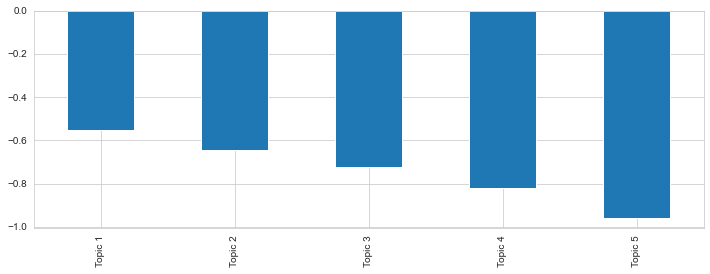

In [20]:

print(topic_words.head())

pd.Series(topic_coherence, index=topic_labels).plot.bar(figsize=(12,4));

In [21]:

arti = docs.sample(1).squeeze()

parsed_b = TextBlob(arti.article)
parsed_b.sentiment
train = pd.DataFrame()

In [22]:
def estimate_polarity(text):
    return TextBlob(text).sentiment.polarity

In [32]:
newlvl = docs[['article']].sample(500).assign(sentiment=lambda x: x.article.apply(estimate_polarity)).sort_values('sentiment')

In [35]:
newlvl[newlvl['sentiment'] < .60]

,article,sentiment
1625,executives caitlin kontulis senior director of...,-0.25
1612,day 15 link royal mail s roymf ceo rico back o...,-0.08
34,symbol adwpf month 6 day 12 year 19 link andre...,-0.07
835,day 14 link genenews limited gnwsf ceo james h...,-0.07
967,symbol idt month 6 day 3 year 18 quarter q3,0.00
...,...,...
686,executives michael schall president and ceo ex...,0.23
1332,company participants 0 spencer wang ir reed ha...,0.24
1037,executives robert macleod ceo executives anna ...,0.32
1555,symbol pvtl month 6 day 4 year 19 link pivotal...,0.50


In [ ]:


word_count = docs.article.str.split().str.len().sum()
print(f'Total word count: {word_count:,d} | per article: {word_count/len(docs):,.0f}')


token_count = Counter()
for i, doc in enumerate(docs.article.tolist(), 1):
    if i % 500 == 0:
        print(i, end=' ', flush=True)
    token_count.update([t.strip() for t in doc.split()])
    
    
tokens = (pd.DataFrame(token_count.most_common(), columns=['token', 'count'])
          .set_index('token')
          .squeeze())

Total word count: 4,856,950 | per article: 2,280
500 1000 1500 2000 

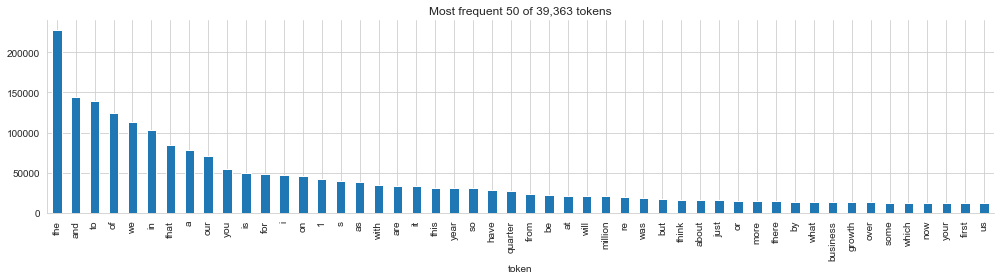

In [ ]:



n = 50
(tokens
 .iloc[:50]
 .plot
 .bar(figsize=(14, 4), title=f'Most frequent {n} of {len(tokens):,d} tokens'))
sns.despine()
plt.tight_layout();

In [ ]:
binary_vectorizer = CountVectorizer(max_df=1.0,
                                    min_df=1,
                                    binary=True)

binary_dtm = binary_vectorizer.fit_transform(docs.article)

n_docs, n_tokens = binary_dtm.shape

tokens_dtm = binary_vectorizer.get_feature_names()

In [ ]:
tokens.index.difference(pd.Index(tokens_dtm))

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd',
       'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r',
       's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'â', 'ã'],
      dtype='object')

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

import pyprind
import pandas as pd
import os
from sklearn.preprocessing import OneHotEncoder


basepath = 'data/movie_data.csv'

df = pd.read_csv(basepath, encoding='utf-8' )


df.columns = ['review', 'sentiment']

df['review'] = df['review'].apply(preprocessor)

X_train = df.loc[:25000, 'review'].values
y_train = df.loc[:25000, 'sentiment'].values
X_test = df.loc[25000:, 'review'].values
y_test = df.loc[25000:, 'sentiment'].values

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

param_grid = [{'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]},
              {'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'vect__use_idf':[False],
               'vect__norm':[None],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]},
              ]

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', LogisticRegression(random_state=0, solver='liblinear'))])

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=2,
                           n_jobs=-1)

#gs_lr_tfidf.fit(X_train, y_train)


print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
print('CV Accuracy: %.3f' % gs_lr_tfidf.best_score_)

NameError: name 'stop' is not defined